# 

# GEX and PPI analysis

This notebook will provide preliminary analyses of the human interactome and single-cell gene expression data from U2OS cells with the goal of deriving a cell-type specific interactome network.

---

## 0. Environmental setup

In [76]:
import pandas as pd
import scanpy as sc
import numpy as np
import os
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.pyplot as plt
from matplotlib_venn import venn3
from venn import venn

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

---
## 1. Read in data

### 1a. Interactome data

First, we will read in the adjacency matrix defining the human interactome as defined by the iRefIndex database v17.

In [2]:
ppi_adj = pd.read_csv(
    "/home/daniel/PycharmProjects/image2reg/data/ppi/irefindex_v17/irefindex_v17.csv"
)
ppi_adj.head()

,Gene1,Gene2,Score.hpr.max,Score.lpr.max,Score.np.max
0,CDKN1A,A1BG,4356,4356,1
1,GLIPR1,A1BG,8,8,1
2,LGALS3,A1BG,19,19,1
3,PRDX4,A1BG,4904,4904,1
4,UBR4,A1BG,60871,60871,1


<IPython.core.display.Javascript object>

In [3]:
print(
    "Interactome consist of {} unique genes and {} interactions.".format(
        len(np.unique((np.array(ppi_adj.iloc[:, :2])).flatten())), len(ppi_adj)
    )
)

Interactome consist of 17437 unique genes and 396984 interactions.


<IPython.core.display.Javascript object>

The adjacency matrix defines the gene interactions and provides additional scores that are described [here](http://wodaklab.org/iRefWeb/faq). Those scores could be used to filter out e.g. interactions only supported by few publications respectively only shown in high- or medium-throughput studies.

### 1b. Gene expression data

Next, we will load the gene expression data that is obtained by a MerFish experiment of U2OS cells from [Xia et al. (2019)](https://www.pnas.org/content/116/39/19490.abstract).

In [4]:
url_counts = "https://www.pnas.org/highwire/filestream/887973/field_highwire_adjunct_files/12/pnas.1912459116.sd12.csv"
filename_counts = "pnas.1912459116.sd12.csv"
urllib.request.urlretrieve(url_counts, filename_counts)

('pnas.1912459116.sd12.csv', <http.client.HTTPMessage at 0x7fee264afca0>)

<IPython.core.display.Javascript object>

In [5]:
counts = sc.read_csv("./pnas.1912459116.sd12.csv").transpose()

<IPython.core.display.Javascript object>

In [6]:
adata = counts

<IPython.core.display.Javascript object>

The single-cell gene expression data set consists of 1368 cells for which 12903 gene were measured by barcoded RNA-sequences.

### 1c. Target gene set

Finally, we will load the gene set that defines the overexpression targets of the image-based high-throughput screen of this cell line from [Rohban et al. (2017)](https://elifesciences.org/articles/24060).

In [7]:
orf_screen_metadata = pd.read_csv(
    "/home/daniel/PycharmProjects/image2reg/data/images/metadata/metadata_images.csv"
)

<IPython.core.display.Javascript object>

In [8]:
target_genes_orf = set(
    np.unique(orf_screen_metadata.loc[:, "Image_Metadata_GeneSymbol"])
)
controls = set(["eGFP", "EMPTY", "LacZ", "Luciferase"])
target_genes_orf = list(target_genes_orf - controls)
len(target_genes_orf)

190

<IPython.core.display.Javascript object>

There are 190 genes in that set.

---

## 2. Preprocessing

We will now analyze the gene expression data set to identify the most variable genes. We suspect a subset of these genes to explain the structural heterogeneity that we observe for unperturbed U2OS cells. Thus, we will focus on those genes in our analyses.

We will run a classic single-cell gene expression analyses pipeline to identify those genes.

We will first filter out cells that express not at least 200 different genes as well as genes that are not expressed in at least 10 cells.

In [9]:
adata.var["n_cells_per_gene"] = np.sum((np.array(adata.to_df()) > 0), axis=0)
adata.obs["n_genes_per_cell"] = np.sum((np.array(adata.to_df())) > 0, axis=1)

<IPython.core.display.Javascript object>

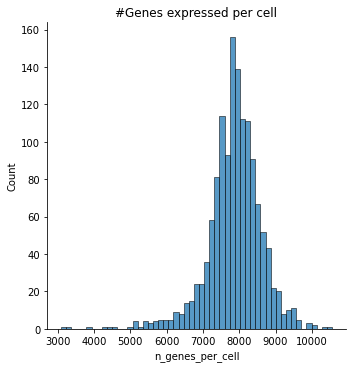

<IPython.core.display.Javascript object>

In [10]:
sns.displot(adata.obs["n_genes_per_cell"])
plt.title("#Genes expressed per cell")
plt.show()

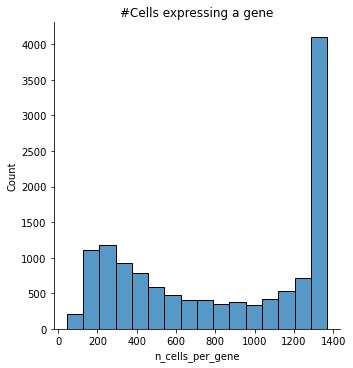

<IPython.core.display.Javascript object>

In [11]:
sns.displot(adata.var["n_cells_per_gene"])
plt.title("#Cells expressing a gene")
plt.show()

The above plots show the distributions of how many genes are expressed per cell respectively how many cells express each gene. The plots suggest some basic filtering removing all genes that are not at least expressed in 10 cells. We will not filter out any cells for now as there are no cells that express less than 3000 genes.

In [12]:
adata = adata[:, adata.var.n_cells_per_gene > 10]
adata

View of AnnData object with n_obs × n_vars = 1368 × 12903
    obs: 'n_genes_per_cell'
    var: 'n_cells_per_gene'

<IPython.core.display.Javascript object>

We see that there are in fact no genes that fails this filtering step. We will now normalize the data to account for unequal sequencing depth and log1p transform the data.

In [13]:
sc.pp.normalize_total(adata, target_sum=1e6)

/usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


<IPython.core.display.Javascript object>

In [14]:
sc.pp.log1p(adata)

<IPython.core.display.Javascript object>

To identify the highly variable genes using the method described in [Stuart et al. (2019)](https://www.sciencedirect.com/science/article/pii/S0092867419305598). Thereby, the highly variable genes are selected by ranking them according to their variance after transforming the raw data by z-scoring it and scaling it with a regularized standard deviation. We select the 300 most variable genes to limit the complexity of the downstream analyses.

In [15]:
sc.pp.highly_variable_genes(adata, n_top_genes=300, flavor="seurat_v3")

/usr/share/miniconda3/envs/image2reg/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


<IPython.core.display.Javascript object>

In [16]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

<IPython.core.display.Javascript object>

The highly variable genes are the following.

In [17]:
variable_genes = set(adata.var_names)
variable_genes

{'ABI2',
 'ADAMTS12',
 'ADGRL2',
 'ADRA1B',
 'AGRN',
 'AHNAK2',
 'ALPK2',
 'ALPP',
 'ANKRD1',
 'ANKRD36',
 'ANO2',
 'ANOS1',
 'ANXA2',
 'ANXA8L1',
 'AQP1',
 'ARHGAP29',
 'ARID5B',
 'ASPM',
 'BCAT1',
 'BHLHE40',
 'BMP4',
 'BMP5',
 'BMS1P1',
 'BORA',
 'BRIP1',
 'BTG2',
 'BUB1B',
 'C1orf198',
 'CADM4',
 'CALM2',
 'CAMK2N1',
 'CAV1',
 'CCDC14',
 'CCDC144NL',
 'CCND2',
 'CCNF',
 'CD274',
 'CD44',
 'CDC20',
 'CDC25A',
 'CDC6',
 'CDH4',
 'CDKN2C',
 'CENPF',
 'CENPI',
 'CGN',
 'CITED2',
 'CKAP2',
 'CKAP2L',
 'CLDN1',
 'COL12A1',
 'COL8A1',
 'CORO1C',
 'CREB5',
 'CRMP1',
 'CSDC2',
 'CTGF',
 'DCAF12L1',
 'DCBLD1',
 'DCBLD2',
 'DCHS2',
 'DCLK1',
 'DDIT4',
 'DDX17',
 'DDX39B',
 'DHRS2',
 'DHRS3',
 'DLGAP5',
 'DPY19L2P1',
 'DSCC1',
 'DTL',
 'DUSP1',
 'DUSP5',
 'DYNC1LI2',
 'E2F1',
 'E2F2',
 'EDA2R',
 'EDN1',
 'EFEMP1',
 'EFR3B',
 'EGFR',
 'ELFN1',
 'EMP1',
 'ENC1',
 'ENDOD1',
 'ENG',
 'EPAS1',
 'EPB41L2',
 'EPHA2',
 'ERRFI1',
 'F2R',
 'FAM111B',
 'FAM20C',
 'FAM212B',
 'FAM46B',
 'FAR2P2',
 'FASN',

<IPython.core.display.Javascript object>

The intersection of those with our gene targets spans only 9 genes. Importantly, however all 12k genes that were orginally measured only include 120 of the 190 targets of the ORF screen.

In [18]:
variable_genes.intersection(target_genes_orf)

{'DDIT4', 'DUSP1', 'E2F1', 'HSPA5', 'IRS1', 'JAG1', 'JUN', 'SOCS3', 'VEGFC'}

<IPython.core.display.Javascript object>

Since we want to include all target genes in the induced subgraph that describes the interactome of U2OS cells, we will refine the PPI by subsetting it to the interactions between any of the 300 most variable genes and the 190 ORF targets. This final gene set consists of 481 genes.

In [19]:
u2os_geneset = variable_genes.union(target_genes_orf)
len(u2os_geneset)

481

<IPython.core.display.Javascript object>

---

## 3. Protein-Protein Interaction network analyses

### 3a. Visualization

We will derive the subgraph of the human interactome spanning the 481 genes that we previously identified as being highly variable and/or part of the 190 genes that were targeted by the ORF screen.

In [20]:
edgelist = np.array(ppi_adj.iloc[:, :2])
human_interactome = nx.from_edgelist(edgelist)

<IPython.core.display.Javascript object>

We find that that there is one gene target of the ORF screen that is not in the set of proteins describing the human interactome as defined by the iRefIndex database v17. This gene is MEK1.

In [21]:
set(target_genes_orf) - set(human_interactome.nodes)

{'MEK1'}

<IPython.core.display.Javascript object>

We will now derive the subgraph that defines the subset of the highly variable genes and the ORF targets.

In [44]:
u2os_interactome = human_interactome.subgraph(list(u2os_geneset))
selfloops = nx.selfloop_edges(u2os_interactome)
u2os_interactome = u2os_interactome.copy()

<IPython.core.display.Javascript object>

We remove the self-loops.

In [46]:
u2os_interactome.remove_edges_from(list(selfloops))

<IPython.core.display.Javascript object>

In [47]:
print(
    "The subgraph consists of {} nodes and {} edges.".format(
        len(u2os_interactome.nodes), len(u2os_interactome.edges)
    )
)

The subgraph consists of 451 nodes and 2619 edges.


<IPython.core.display.Javascript object>

In [48]:
print(nx.info(u2os_interactome))

Name: 
Type: Graph
Number of nodes: 451
Number of edges: 2619
Average degree:  11.6142


<IPython.core.display.Javascript object>

We see that the subgraph actually only contains 451 of the 481 genes. A possible explanation could be that a) have not been yet studied with respect to their possible interactions, b) the genes were renamed or the corresponding protein name does not 1-to-1 corresponds to the name of the gene.

In [54]:
print(
    "The interactome consists of {} connected components.".format(
        nx.number_connected_components(u2os_interactome)
    )
)

The interactome consists of 68 connected components.


<IPython.core.display.Javascript object>

Out of these connected components one consist of 383 nodes, one of 2 nodes and the remaining ones are singeltons. Importantly, only 3 of the genes of targets of the ORF screen are not part of the largest connected component (one is not featured at all as it is not part of the vertices of the human interactome).

In [58]:
connected_components = [
    c
    for c in sorted(nx.connected_components(u2os_interactome), key=len, reverse=True)
]

largest_connected_component = connected_components[0]
len(set(largest_connected_component).intersection(target_genes_orf))


186

<IPython.core.display.Javascript object>

In [29]:
nx.to_pandas_edgelist(u2os_interactome).to_csv(
    "u2os_interactome_edgelist.csv", index=False
)

<IPython.core.display.Javascript object>

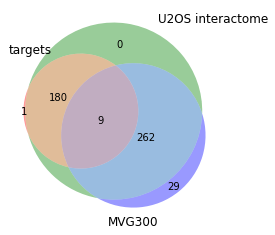

<IPython.core.display.Javascript object>

In [78]:
venn3(
    [set(target_genes_orf), set(list(u2os_interactome.nodes)), set(variable_genes)],
    ["targets", "U2OS interactome", "MVG300"],
)
plt.show()

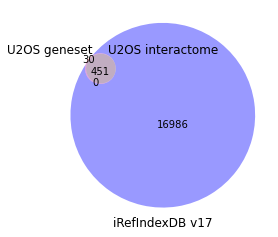

<IPython.core.display.Javascript object>

In [83]:
venn3(
    [
        set(u2os_geneset),
        set(list(u2os_interactome.nodes)),
        set(list(human_interactome.nodes)),
    ],
    ["U2OS geneset", "U2OS interactome", "iRefIndexDB v17"],
)
plt.show()

In [73]:
list(target_genes_orf)

['PPP2R5C',
 'STAT1',
 'PDPK1',
 'AKT1S1',
 'DLL1',
 'CDKN1A',
 'FGFR3',
 'GRB10',
 'RAC1',
 'ARAF',
 'HIF1AN',
 'DVL1',
 'HSP90AA1',
 'ERN1',
 'MAP3K9',
 'DUSP1',
 'HSP90B1',
 'BRAF',
 'TSC1',
 'STAT3',
 'SRC',
 'RHOA',
 'CDK4',
 'IRAK4',
 'MLST8',
 'FH',
 'PTEN',
 'SREBF1',
 'CTNNB1',
 'XBP1',
 'RPTOR',
 'EIF4EBP1',
 'MAP3K8',
 'STK11',
 'PRKCZ',
 'ATG16L1',
 'SMAD4',
 'PAK1',
 'CHUK',
 'TSC2',
 'IKBKB',
 'WWTR1',
 'TBK1',
 'TGFBR1',
 'PPARGC1A',
 'DDIT4',
 'JAG1',
 'PRKACA',
 'RELA',
 'MEK1',
 'DKK1',
 'MCL1',
 'PER1',
 'SMAD7',
 'BCL2L11',
 'TCF4',
 'GLI1',
 'MYD88',
 'SLIRP',
 'TRAF6',
 'AKT3',
 'MAP2K1',
 'PRKACG',
 'PRKCE',
 'WNT5A',
 'CASP8',
 'MAP3K5',
 'NFKBIE',
 'BTRC',
 'ERBB2',
 'RAF1',
 'XIAP',
 'MAP2K3',
 'TRAF5',
 'STK3',
 'NOTCH2',
 'TP53',
 'KRAS',
 'CRY1',
 'TRAF2',
 'E2F1',
 'MAPK14',
 'MAPK13',
 'LRPPRC',
 'AXIN2',
 'SMAD3',
 'MAPK3',
 'CREB1',
 'IRS1',
 'PIK3R2',
 'SDHA',
 'JAK2',
 'MAPKAP1',
 'PHLPP1',
 'CCNE1',
 'RELB',
 'DVL2',
 'ATF6',
 'IRAK1',
 'RICTOR',
 'S

<IPython.core.display.Javascript object>